In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import statsmodels.api as sm 

# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Read training data
car_df = pd.read_csv("CarPrice_Assignment.csv")

In [202]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [203]:
car_df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [204]:
#car_df.isnull().sum()
car_df.describe()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


### Data Cleaning

In [205]:
# Id Adds no real value to analysis so removing it 
car_df.drop(['car_ID'], axis =1, inplace = True)

#### Cleaning car name

In [206]:
car_df['CarName']=car_df['CarName'].apply(lambda x: x.split(" ")[0])

In [207]:
car_df['CarName'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

In [208]:
def correctcarnames(name):
    if(name=='maxda'):
        return 'mazda'
    if(name=='Nissan'):
        return 'nissan'
    if(name=='porcshce'):
        return 'porsche'
    if(name=='toyouta'):
        return 'toyota'
    if(name=='vokswagen' or name=='vw'):
        return 'volkswagen'
    else:
        return name

In [209]:
car_df['CarName']=car_df['CarName'].apply(correctcarnames)

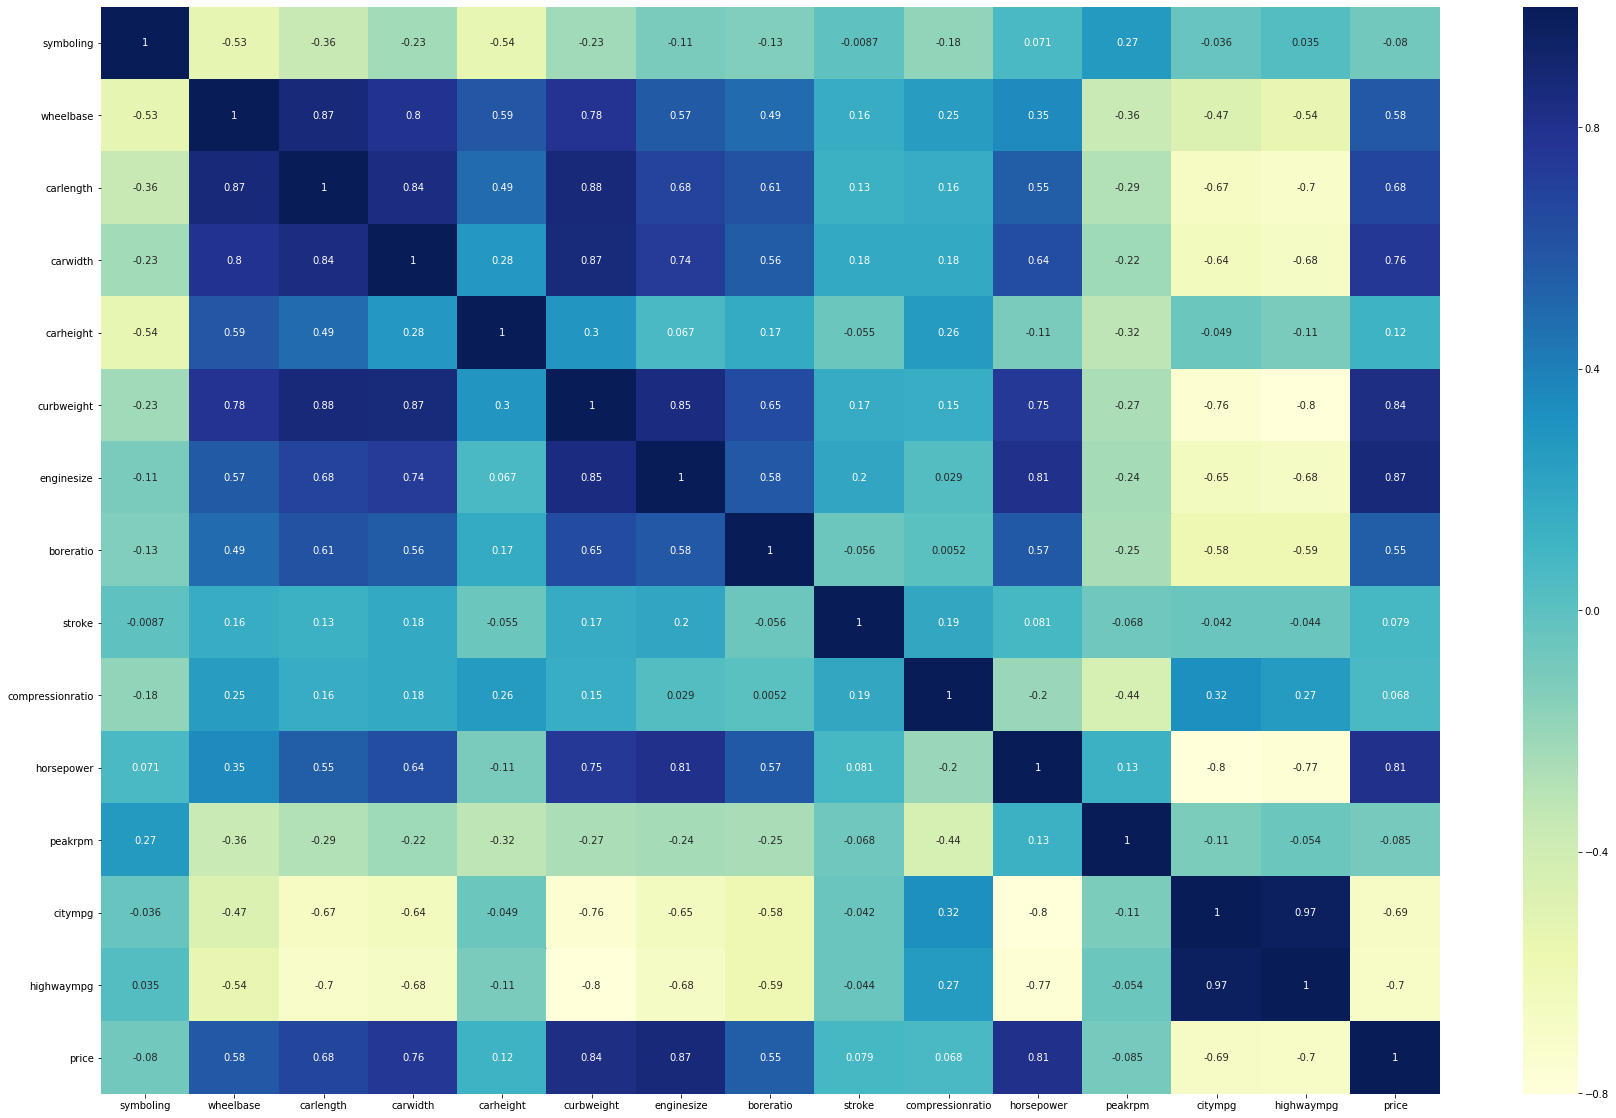

In [210]:
plt.figure(figsize = (30,20))
sns.heatmap(car_df.corr(),annot=True,cmap="YlGnBu")

#### mileage

In [211]:
# Averageing city and highway mileage to create single variable as the two variables are highly correlated
car_df['mpg']=(car_df['citympg']+car_df['highwaympg'])/2

In [212]:
car_df.drop(['citympg','highwaympg'], axis =1, inplace = True)

#### Wheel base vs Car length

In [213]:
#Wheel base is highly correlated to car lenght as it measures length between front and rear wheels, 
# which accounts for most length of the car.

In [214]:
car_df.drop(['wheelbase'], axis =1, inplace = True)

#### Curb weight and Carwidth

In [215]:
#Curb weight is empty weight of the car , which is highly correlated to lenght, width and engine size of the car,
#Carwidth is highly correlated to car lenght and business logic also validates, cars that are longer tend to be wider as well.
#so they can be removed

In [216]:
car_df.drop(['curbweight','carwidth'], axis =1, inplace = True)

In [217]:
car_df.nunique()

symboling             6
CarName              22
fueltype              2
aspiration            2
doornumber            2
carbody               5
drivewheel            3
enginelocation        2
carlength            75
carheight            49
enginetype            7
cylindernumber        7
enginesize           44
fuelsystem            8
boreratio            38
stroke               37
compressionratio     32
horsepower           59
peakrpm              23
price               189
mpg                  46
dtype: int64

In [218]:
# Category variables
# 'CarName','fueltype','aspiration','doornumber','carbody','drivewheel','enginelocation','enginetype','cylindernumber','fuelsystem'
# Binrary Category variables
# 'fueltype','doornumber','aspiration','enginelocation'

### Data preparation

In [219]:
# Applying the function to the cars df
car_df[['fueltype']] = car_df[['fueltype']].apply(lambda x:x.map({'gas': 1, 'diesel': 0}))
car_df[['doornumber']] = car_df[['doornumber']].apply(lambda x:x.map({'four': 1, 'two': 0}))
car_df[['aspiration']] = car_df[['aspiration']].apply(lambda x:x.map({'std': 1, 'turbo': 0}))
car_df[['enginelocation']] = car_df[['enginelocation']].apply(lambda x:x.map({'front': 1, 'rear': 0}))

In [220]:
car_df.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,carlength,carheight,...,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,price,mpg
0,3,alfa-romero,1,1,0,convertible,rwd,1,168.8,48.8,...,four,130,mpfi,3.47,2.68,9.0,111,5000,13495.0,24.0
1,3,alfa-romero,1,1,0,convertible,rwd,1,168.8,48.8,...,four,130,mpfi,3.47,2.68,9.0,111,5000,16500.0,24.0
2,1,alfa-romero,1,1,0,hatchback,rwd,1,171.2,52.4,...,six,152,mpfi,2.68,3.47,9.0,154,5000,16500.0,22.5
3,2,audi,1,1,1,sedan,fwd,1,176.6,54.3,...,four,109,mpfi,3.19,3.40,10.0,102,5500,13950.0,27.0
4,2,audi,1,1,1,sedan,4wd,1,176.6,54.3,...,five,136,mpfi,3.19,3.40,8.0,115,5500,17450.0,20.0


In [221]:
def createdummies(df,column):
    status = pd.get_dummies(df[column])
    df = pd.concat([df, status], axis = 1)
    df.drop([column], axis = 1, inplace = True)
    return df

In [222]:
car_df=createdummies(car_df,'CarName')
car_df=createdummies(car_df,'carbody')
car_df=createdummies(car_df,'drivewheel')
car_df=createdummies(car_df,'fuelsystem')
car_df=createdummies(car_df,'cylindernumber')
car_df=createdummies(car_df,'enginetype')

In [281]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(car_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [224]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [226]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['symboling', 'carlength','carheight','enginesize','boreratio','stroke',
           'compressionratio','horsepower','peakrpm','mpg','price']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [227]:
df_train.describe()

,symboling,fueltype,aspiration,doornumber,enginelocation,carlength,carheight,enginesize,boreratio,stroke,...,three,twelve,two,dohc,dohcv,l,ohc,ohcf,ohcv,rotor
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,...,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,0.559441,0.909091,0.818182,0.559441,0.993007,0.525476,0.509004,0.241351,0.497946,0.535389,...,0.006993,0.006993,0.027972,0.069930,0.006993,0.062937,0.685315,0.083916,0.062937,0.027972
std,0.239200,0.288490,0.387050,0.498199,0.083624,0.204848,0.215378,0.154619,0.207140,0.157843,...,0.083624,0.083624,0.165472,0.255926,0.083624,0.243703,0.466023,0.278236,0.243703,0.165472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,1.000000,1.000000,0.000000,1.000000,0.399187,0.353982,0.135849,0.305556,0.464646,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.600000,1.000000,1.000000,1.000000,1.000000,0.502439,0.522124,0.184906,0.500000,0.545455,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.600000,1.000000,1.000000,1.000000,1.000000,0.669919,0.668142,0.301887,0.682540,0.611111,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [228]:
y_train = df_train.pop('price')
X_train = df_train

In [229]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [230]:
# Using TOP 20 features from RFE after expermenting with different values

In [231]:
rfe =  RFE(lm,15)
rfe=rfe.fit(X_train,y_train)
print(rfe.support_)           
print(rfe.ranking_)

[False False False False False  True False  True  True  True False False
 False False False  True  True  True False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False  True False  True False  True  True  True False
  True False False False False  True]
[48 25  5 51 41  1 16  1  1  1 52 35  4 50 15  1  1  1 21 17 20 34 19 43
 46  6 26  2 14  1 23 10 28 45 24 11  9 32 31 33 37 44 36 40 38 27 39 29
 47 42 18 49  1 12  1 22  1  1  1  8  1  3 13 30  7  1]


In [232]:
X_train.columns[rfe.support_]

Index(['carlength', 'enginesize', 'boreratio', 'stroke', 'audi', 'bmw',
       'buick', 'porsche', 'eight', 'four', 'three', 'twelve', 'two', 'dohcv',
       'rotor'],
      dtype='object')

In [233]:
#Top Drivers
#'aspiration', 'carlength', 'enginesize', 'boreratio', 'stroke',
#'peakrpm', 'audi', 'bmw', 'buick', 'mitsubishi', 'peugeot', 'porsche',
#'eight', 'four', 'three', 'twelve', 'two', 'dohcv', 'l', 'rotor'

varlist=['carlength', 'enginesize', 'boreratio', 'stroke', 'audi', 'bmw',
       'buick', 'porsche', 'eight', 'four', 'three', 'twelve', 'two', 'dohcv',
       'rotor']

In [257]:
X_train_new=X_train[varlist]

In [258]:
def getdetails(X_train_new,y_train):
    X_train_new = sm.add_constant(X_train_new)
    lr = sm.OLS(y_train,X_train_new).fit()
    #Let's see the summary of our linear model
    print(lr.summary())
    X_train_new = X_train_new.drop(['const'], axis=1)
    vif = pd.DataFrame()
    X = X_train_new
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)
    return lr

In [259]:
lr_1=getdetails(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     96.18
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           8.94e-61
Time:                        08:13:15   Log-Likelihood:                 191.70
No. Observations:                 143   AIC:                            -353.4
Df Residuals:                     128   BIC:                            -309.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1810      0.042     -4.264      0.0

In [260]:
col_2=X_train_new.pop('dohcv')
lr_2=getdetails(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     101.4
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           4.78e-61
Time:                        08:13:18   Log-Likelihood:                 189.78
No. Observations:                 143   AIC:                            -351.6
Df Residuals:                     129   BIC:                            -310.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1619      0.042     -3.892      0.0

In [261]:
col_3=X_train_new.pop('eight')
lr_3=getdetails(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     107.5
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           2.37e-61
Time:                        08:13:19   Log-Likelihood:                 187.92
No. Observations:                 143   AIC:                            -349.8
Df Residuals:                     130   BIC:                            -311.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1516      0.042     -3.644      0.0

In [262]:
col_4=X_train_new.pop('two')
lr_4=getdetails(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     107.5
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           2.37e-61
Time:                        08:13:20   Log-Likelihood:                 187.92
No. Observations:                 143   AIC:                            -349.8
Df Residuals:                     130   BIC:                            -311.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1516      0.042     -3.644      0.0

In [264]:
col_5=X_train_new.pop('boreratio')
lr_5=getdetails(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     108.9
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           2.67e-60
Time:                        08:13:48   Log-Likelihood:                 182.61
No. Observations:                 143   AIC:                            -341.2
Df Residuals:                     131   BIC:                            -305.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1200      0.042     -2.874      0.0

In [265]:
col_6=X_train_new.pop('four')
lr_6=getdetails(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     120.6
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           2.44e-61
Time:                        08:14:19   Log-Likelihood:                 182.57
No. Observations:                 143   AIC:                            -343.1
Df Residuals:                     132   BIC:                            -310.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1118      0.026     -4.257      0.0

In [266]:
col_7=X_train_new.pop('twelve')
lr_7=getdetails(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     133.9
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           3.36e-62
Time:                        08:14:30   Log-Likelihood:                 182.03
No. Observations:                 143   AIC:                            -344.1
Df Residuals:                     133   BIC:                            -314.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1171      0.026     -4.549      0.0

In [267]:
col_8=X_train_new.pop('stroke')
lr_8=getdetails(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     151.1
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           3.47e-63
Time:                        08:14:47   Log-Likelihood:                 181.74
No. Observations:                 143   AIC:                            -345.5
Df Residuals:                     134   BIC:                            -318.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1310      0.018     -7.486      0.0

In [268]:
col_9=X_train_new.pop('three')
lr_9=getdetails(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     169.3
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           1.32e-63
Time:                        08:14:54   Log-Likelihood:                 179.98
No. Observations:                 143   AIC:                            -344.0
Df Residuals:                     135   BIC:                            -320.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1233      0.017     -7.198      0.0

In [269]:
col_10=X_train_new.pop('enginesize')
lr_10=getdetails(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     69.43
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           5.50e-39
Time:                        08:15:18   Log-Likelihood:                 117.19
No. Observations:                 143   AIC:                            -220.4
Df Residuals:                     136   BIC:                            -199.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1374      0.026     -5.199      0.0

In [270]:
col_11=X_train_new.pop('rotor')
lr_11=getdetails(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     82.13
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           1.72e-39
Time:                        08:15:32   Log-Likelihood:                 116.02
No. Observations:                 143   AIC:                            -220.0
Df Residuals:                     137   BIC:                            -202.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1333      0.026     -5.048      0.0

In [271]:
col_12=X_train_new.pop('audi')
lr_12=getdetails(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     100.4
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           7.13e-40
Time:                        08:15:44   Log-Likelihood:                 114.46
No. Observations:                 143   AIC:                            -218.9
Df Residuals:                     138   BIC:                            -204.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1378      0.026     -5.209      0.0

In [289]:
# Observed drastic drop in R squared value on removing engine size so adding back

In [272]:
X_train_new=pd.concat([X_train_new,col_10], axis=1)

In [273]:
lr_13=getdetails(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     173.3
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           2.04e-57
Time:                        08:16:38   Log-Likelihood:                 159.32
No. Observations:                 143   AIC:                            -306.6
Df Residuals:                     137   BIC:                            -288.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1209      0.019     -6.209      0.0

In [274]:
col_14=X_train_new.pop('carlength')
lr_14=getdetails(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     174.4
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           6.24e-53
Time:                        08:17:10   Log-Likelihood:                 145.73
No. Observations:                 143   AIC:                            -281.5
Df Residuals:                     138   BIC:                            -266.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0438      0.014     -3.048      0.0

## Residual Analysis of the train data

In [275]:
X_train_lm = sm.add_constant(X_train_new)

In [276]:
y_predict=lr_14.predict(X_train_lm)

Text(0.5, 0, 'Errors')

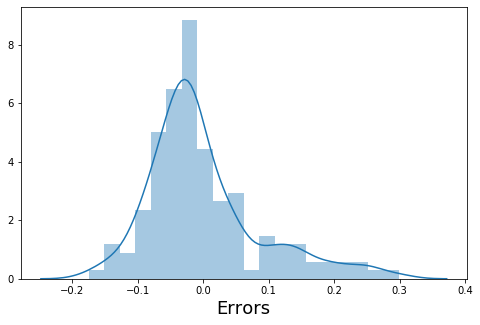

In [277]:
plt.figure(figsize=(8,5))
sns.distplot((y_train-y_predict),bins=20)
plt.xlabel('Errors', fontsize = 18)                         

In [278]:
from sklearn.metrics import mean_squared_error, r2_score

In [279]:
mse = mean_squared_error(y_train, y_predict)
r_squared = r2_score(y_train, y_predict)

print('Mean_Squared_Error :' ,mse)
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.007627215491666182
r_square_value : 0.834885047837717


### Making Predictions

In [282]:
#'aspiration','carlength','four','dohcv','eight','porsche','bmw','twelve'
# scaling only numeric variables for test dataset
num_vars =['enginesize','price']
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [283]:
y_test = df_test.pop('price')
X_test = df_test

In [284]:
X_test_new = X_test[X_train_new.columns]
X_test_new = sm.add_constant(X_test_new)

In [285]:
# Making predictions
y_pred = lr_14.predict(X_test_new)
# y_pred.shape
# y_test.shape

In [286]:
from sklearn.metrics import mean_squared_error, r2_score

In [287]:
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print('Mean_Squared_Error :' ,mse)
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.008085652322108536
r_square_value : 0.8152526416676429


### Model Evaluation

Text(0, 0.5, 'Views')

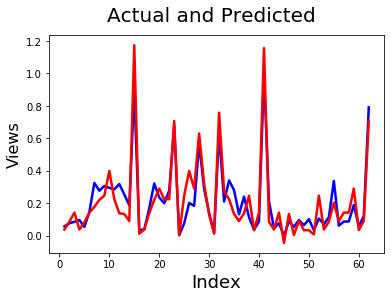

In [288]:
#Actual vs Predicted
c = [i for i in range(1,63,1)]
fig = plt.figure()
plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-")
plt.plot(c,y_pred, color="red",  linewidth=2.5, linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Views', fontsize=16)                               # Y-label

## Result :-

### Main drivers of  deciding car prices are enginesize,bwm,buick,porsche


We can see that the equation of our best fitted line is:

$ price = 1.36  \times  enginesize + 1.17  \times  buick + 1.12 \times bwm + 1.07 \times porsche $
